In [1]:
from settings import *

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

prices는 현재 공휴일이 제외 되지 않았다. 

TODO:

1. 공휴일 제외 데이터를 만들어서(kospi기준) 백테스팅 필요

In [3]:
prices = pd.read_csv('data/assets.csv', index_col=0, parse_dates=True)
tickers = list(prices.columns[:-4])+['현금']

In [4]:
oecd = pd.read_csv("data/OECD.csv", index_col=0, parse_dates=True).rename_axis("Date")
oecd_MOM = oecd.resample('D').first().fillna(method='ffill') #전월비
target_weights1 = pd.DataFrame(np.where(oecd_MOM > 1, 1, 0), index=oecd_MOM.index)
target_weights1['현금'] = 1 - target_weights1
target_weights1.columns = ['base1', '현금'] # 'base1'은 위의 전략과 이름을 맞추어야 한다. '현금'도 prices의 컬럼이름과 맞추어야 한다.


kbase1 = bt.Strategy('kbase1',
    [
        bt.algos.RunAfterDate('2002-1-2'),
        bt.algos.RunMonthly(),
        bt.algos.SelectAll(),
        bt.algos.SelectThese(tickers),
        StatIDAverageMomentumScore(lag=pd.DateOffset(days=0), cash='현금'),
        bt.algos.SelectN(n=1, sort_descending=True),
        # bt.algos.PrintDate(),
        WeighEquallyWithoutCash(target_weights1, cash='현금'),
        # bt.algos.PrintTempData(),
        bt.algos.Rebalance()
    ],
    children=tickers,
)

In [5]:
def AMS(x):
    ''' x : Series (DataFrame의 컬럼)
        x[-1] : 기준일. x의 현재값
        (오늘날짜/과거날짜 - 1) > 0 보다 크면 1, 아니면 0
        => 오늘날짜/과거날짜 > 1 => 오늘날짜 > 과거날짜  => x[-1] > x
    '''
    # print(f"{list(np.where(x[-1]>x, 1, 0)[:-1])}, {len(np.where(x[-1]>x, 1, 0)[:-1])}")
    return np.mean(np.where(x[-1]>x, 1, 0)[:-1]) # 당일 날짜 비교는 제외해준다 [:-1]

In [6]:
dd = pd.read_csv('일별투자자별매매동향대신.csv', index_col=0, parse_dates=True)
외국인수급 = dd.loc['2000':'2021-08', '외국인'].copy().to_frame()
외국인수급.columns = ['kospi']
외국인수급 = 외국인수급 - 외국인수급.min()

외국인수급['ams'] = 외국인수급['kospi'].rolling(252).apply(AMS)

target_weights2 = pd.DataFrame()
target_weights2['ams'] = 외국인수급['ams']
target_weights2['현금'] = 1.0 - target_weights2
target_weights2 = target_weights2.dropna()
target_weights2 = target_weights2.resample('D').fillna(method='ffill').shift(1)
target_weights2.columns = ['base2', '현금'] 

kbase2 = bt.Strategy(
    'kbase2',
    [
        bt.algos.RunAfterDate('2002-1-2'),
        bt.algos.RunMonthly(),
        bt.algos.SelectAll(),
        bt.algos.SelectThese(tickers),
        StatIDAverageMomentumScore(lag=pd.DateOffset(days=0), cash='현금'),
        bt.algos.SelectN(n=2, sort_descending=True),
        # bt.algos.PrintDate(),
        WeighEquallyWithoutCash(target_weights2, cash='현금'),
        # bt.algos.PrintTempData(),
        bt.algos.Rebalance()
    ],
    children=tickers,
)

In [7]:
c='코스피200'
target_weights3 = pd.DataFrame()
target_weights3['base3'] = prices[c].rolling(365).apply(AMS)
target_weights3['현금'] = 1.0 - target_weights3
target_weights3.columns = ['base3', '현금']

kbase3 = bt.Strategy(
    'kbase3',
    [
        bt.algos.RunAfterDate('2002-1-2'),
        bt.algos.RunMonthly(),
        bt.algos.SelectAll(),
        bt.algos.SelectThese(tickers),
        StatIDAverageMomentumScore(lag=pd.DateOffset(days=0), cash='현금'),
        bt.algos.SelectN(n=3, sort_descending=True),
        # bt.algos.PrintDate(),
        WeighEquallyWithoutCash(target_weights3, cash='현금'),
        # bt.algos.PrintTempData(),
        bt.algos.Rebalance()
    ],
    children=tickers,
)

In [8]:
kbase123 = bt.Strategy(
    'kbase123',
    [
        bt.algos.RunAfterDate('2002-1-2'),
        bt.algos.RunMonthly(),
#         bt.algos.PrintDate(),
        bt.algos.SelectAll(),
    #   bt.algos.SelectThese(tickers),
    # 변동성 제어한 비중에 대한 dataframe
        bt.algos.WeighEqually(),
        # bt.algos.PrintTempData(),
        bt.algos.Rebalance()
    ],
    children = [kbase1, kbase2, kbase3]
)

In [9]:
prices_dollar = pd.read_csv('data/dollar_assets.csv', index_col=0, parse_dates=True)
# FIXME 달러자산으로 AMS를 하는게 맞는가 아니면 원화자산에 AMS를 하는게 맞는가?
target_weights4 = pd.DataFrame()
for c in ["나스닥100", "다우"]:
    target_weights4[c] = prices_dollar[c].rolling(365).apply(AMS)
target_weights4 = target_weights4*0.5
target_weights4['달러'] = 1.0 - target_weights4.sum(axis=1)

나스닥다우동일비중AMS = bt.Strategy(
    '나스닥다우동일비중AMS',
    [
        bt.algos.RunAfterDate('2002-1-2'),
        bt.algos.RunMonthly(),
        bt.algos.SelectThese(['나스닥100', '다우', '달러']),
        bt.algos.WeighTarget(target_weights4),
        # WeighEquallyWithoutCash(target_weights, cash='현금'),
        # bt.algos.PrintTempData(),
        bt.algos.Rebalance()
    ]
)

In [10]:
통합 = bt.Strategy(
    '통합',
    [
        bt.algos.RunAfterDate('2002-1-2'),
        bt.algos.RunMonthly(),
        # bt.algos.PrintDate(),
        bt.algos.SelectAll(),
        bt.algos.WeighEqually(),
        # bt.algos.PrintTempData(),
        bt.algos.Rebalance()],
)

In [11]:
bt_kbase1 = bt.Backtest(kbase1, prices)
bt_kbase2 = bt.Backtest(kbase2, prices)
bt_kbase3 = bt.Backtest(kbase3, prices)

bt_kbase123 = bt.Backtest(kbase123, prices)
bt_나스닥다우동일비중AMS = bt.Backtest(나스닥다우동일비중AMS, prices_dollar)

r1 = bt.run(bt_나스닥다우동일비중AMS)
r2 = bt.run(bt_kbase123)

# r = bt.run(bt_kbase1, bt_kbase2, bt_kbase3)
# rr = bt.run(bt_kbase1, bt_kbase2, bt_kbase3, bt_kbase123)

합성지수를 만든다.

In [12]:
data = bt.merge(r1['나스닥다우동일비중AMS'].prices, r2['kbase123'].prices)
data.head()

,나스닥다우동일비중AMS,kbase123
2001-01-01,100.000,100.000
2001-01-02,100.000,100.000
2001-01-03,100.000,100.000
2001-01-04,100.000,100.000
2001-01-05,100.000,100.000


In [13]:
bt_통합 = bt.Backtest(통합, data)
r3 = bt.run(bt_통합)

In [14]:
r3.set_date_range("2002-02-01")
r3.display()

Stat                 통합
-------------------  ----------
Start                2002-02-01
End                  2020-07-02
Risk-free rate       0.00%

Total Return         686.15%
Daily Sharpe         0.89
Daily Sortino        1.40
CAGR                 11.85%
Max Drawdown         -22.84%
Calmar Ratio         0.52

MTD                  1.84%
3m                   13.96%
6m                   8.42%
YTD                  8.00%
1Y                   12.47%
3Y (ann.)            7.20%
5Y (ann.)            9.57%
10Y (ann.)           11.56%
Since Incep. (ann.)  11.85%

Daily Sharpe         0.89
Daily Sortino        1.40
Daily Mean (ann.)    8.15%
Daily Vol (ann.)     9.15%
Daily Skew           0.04
Daily Kurt           9.70
Best Day             6.49%
Worst Day            -4.62%

Monthly Sharpe       1.06
Monthly Sortino      2.13
Monthly Mean (ann.)  11.63%
Monthly Vol (ann.)   10.94%
Monthly Skew         0.17
Monthly Kurt         1.81
Best Month           14.12%
Worst Month          -8.05%

Yearly S

In [15]:
r_all = bt.run(bt_kbase1, bt_kbase2, bt_kbase3, bt_kbase123, bt_나스닥다우동일비중AMS, bt_통합)
r_all.set_date_range("2002-02-01")
r_all.display()

Stat                 kbase1      kbase2      kbase3      kbase123    나스닥다우동일비중AMS    통합
-------------------  ----------  ----------  ----------  ----------  -----------------------  ----------
Start                2002-02-01  2002-02-01  2002-02-01  2002-02-01  2002-02-01               2002-02-01
End                  2020-07-02  2020-07-02  2020-07-02  2020-07-02  2020-07-02               2020-07-02
Risk-free rate       0.00%       0.00%       0.00%       0.00%       0.00%                    0.00%

Total Return         5821.11%    804.24%     858.74%     1755.19%    187.02%                  686.15%
Daily Sharpe         0.87        0.66        0.66        0.86        0.40                     0.89
Daily Sortino        1.37        1.02        1.01        1.38        0.61                     1.40
CAGR                 24.81%      12.70%      13.06%      17.19%      5.89%                    11.85%
Max Drawdown         -29.47%     -30.82%     -40.90%     -31.39%     -22.90%                  -

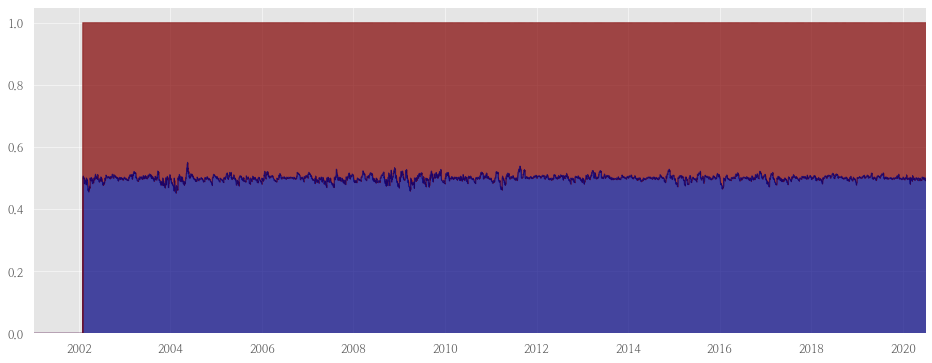

In [16]:
r_all.get_security_weights('통합').plot.area(stacked=True, alpha=0.7, legend=False, cmap='jet', figsize=(16,6));

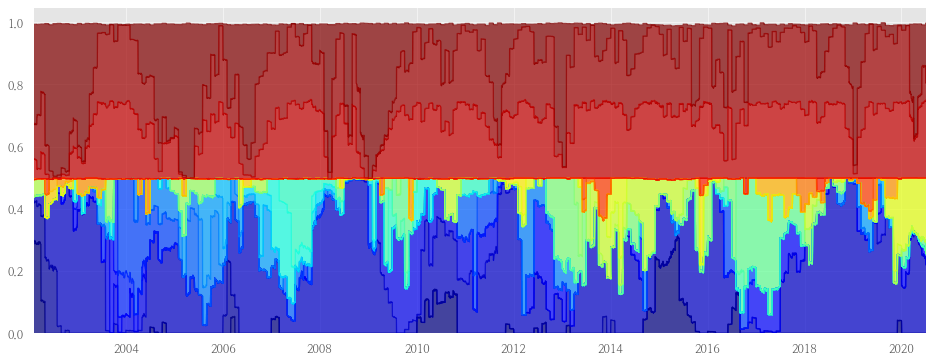

In [17]:
dollar_assets_weights = r1.get_security_weights()*0.5
kbase123_weights = r2.get_security_weights()*0.5
security_weights = bt.merge(kbase123_weights, dollar_assets_weights)
security_weights = security_weights['2002-02-01':]
security_weights.plot.area(stacked=True, alpha=0.7, legend=False, cmap='jet', figsize=(16,6));

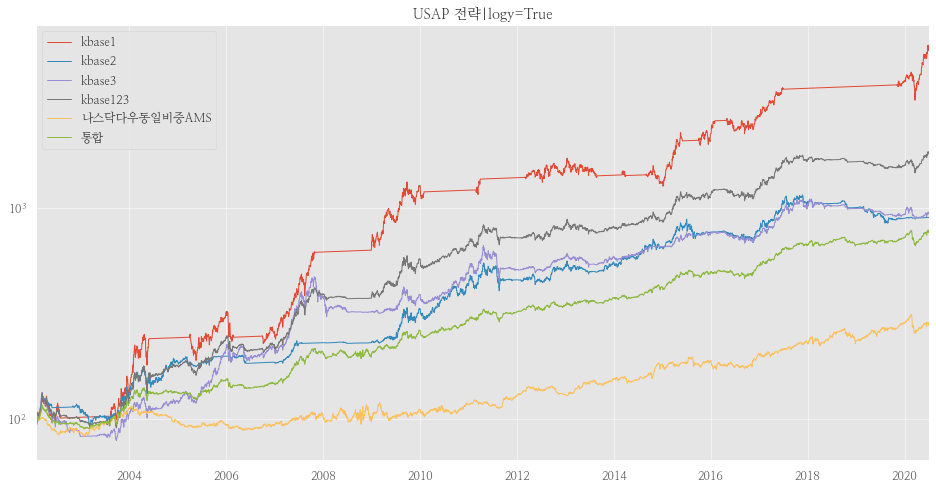

In [18]:
ax = r_all.plot(figsize=(16,8), logy=True, title="USAP 전략|logy=True");
plt.legend(loc="upper left");

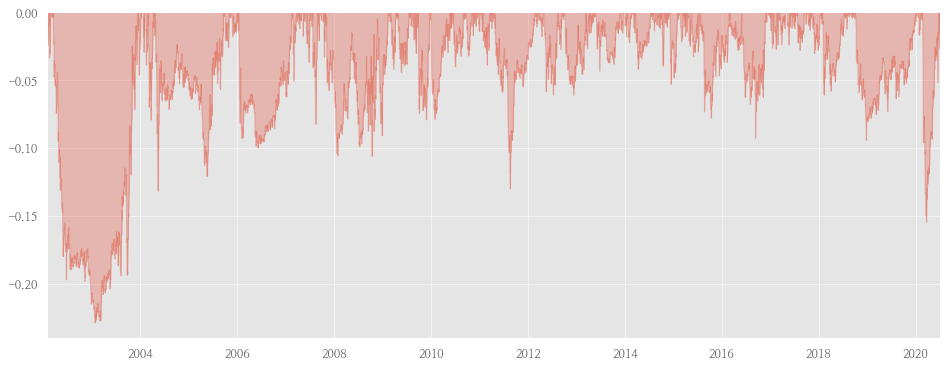

In [19]:
r_all['통합'].prices.to_drawdown_series().plot.area(stacked=False, alpha=0.3, figsize=(16, 6));

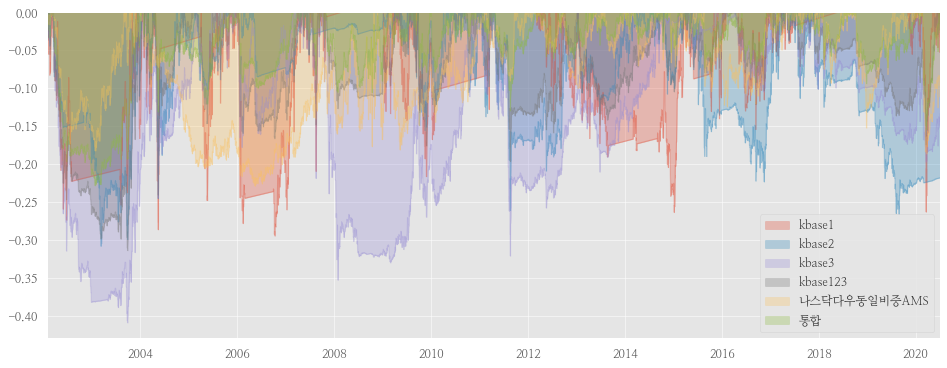

In [20]:
r_all.prices.to_drawdown_series().plot.area(stacked=False, alpha=0.3, figsize=(16, 6));

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2002-02-02  2002-02-02
End Period                 2020-07-02  2020-07-02
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          686.15%     1,755.19%
CAGR﹪                     11.84%      17.18%

Sharpe                     0.89        0.86
Smart Sharpe               0.88        0.86
Sortino                    1.3         1.29
Smart Sortino              1.29        1.27
Sortino/√2                 0.92        0.91
Smart Sortino/√2           0.91        0.9
Omega                      1.21        1.21

Max Drawdown               -22.84%     -31.39%
Longest DD Days            635         930
Volatility (ann.)          9.15%       13.77%
R^2                        0.61        0.61
Calmar                     0.52        0.55
Skew                       0.04        0.21
Kurtosis                   9.7        

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2002-03-20,2003-01-27,2003-12-15,635,-22.843,-22.586
2,2020-02-21,2020-03-23,2020-06-24,124,-15.450,-14.896
3,2004-04-23,2004-05-17,2005-09-22,517,-13.156,-11.775
4,2011-04-27,2011-08-22,2012-02-23,302,-12.992,-11.418
5,2007-10-30,2008-10-15,2009-02-13,472,-10.598,-9.857


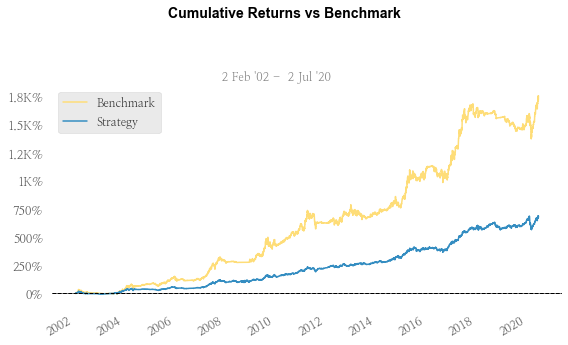

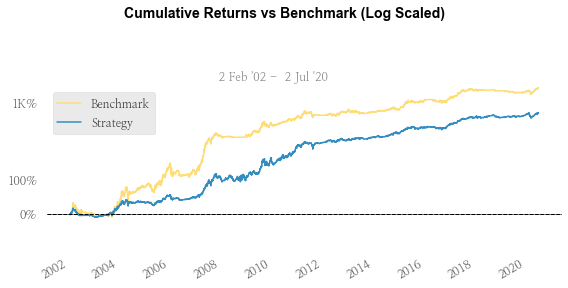

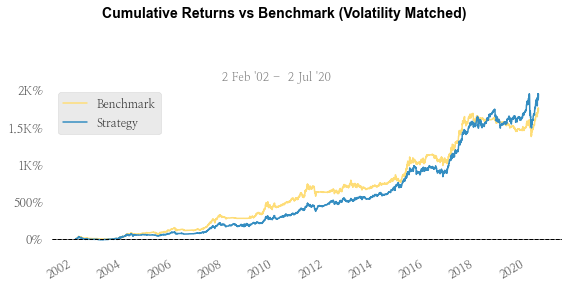

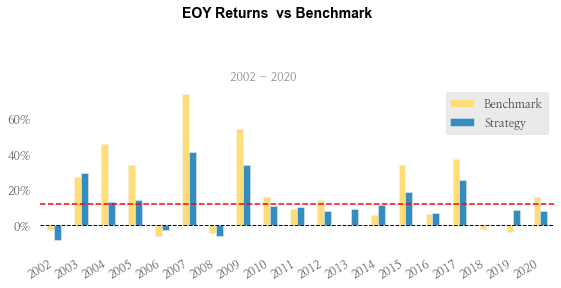

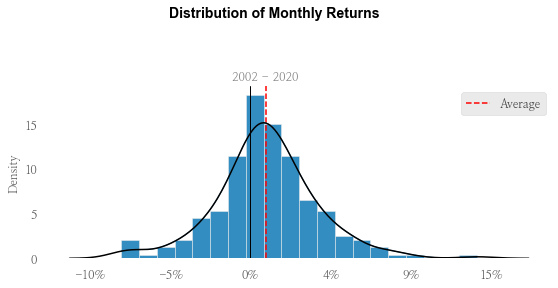

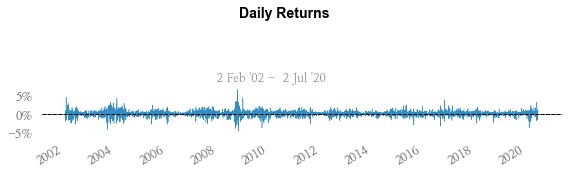

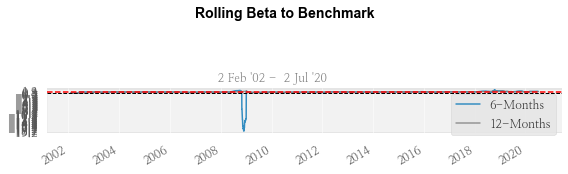

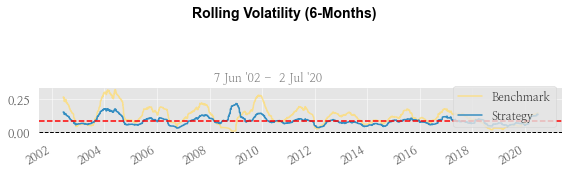

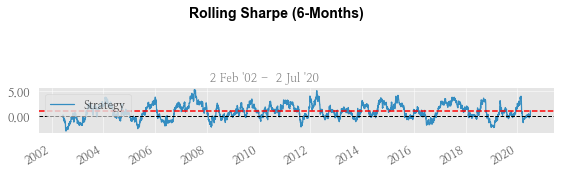

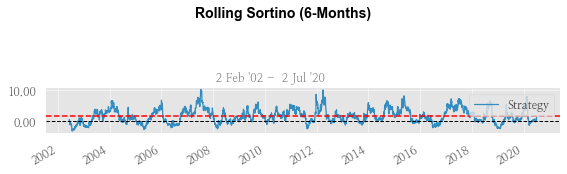

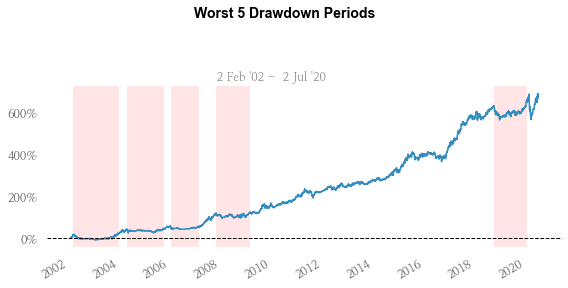

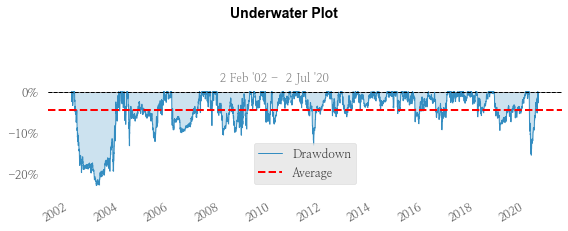

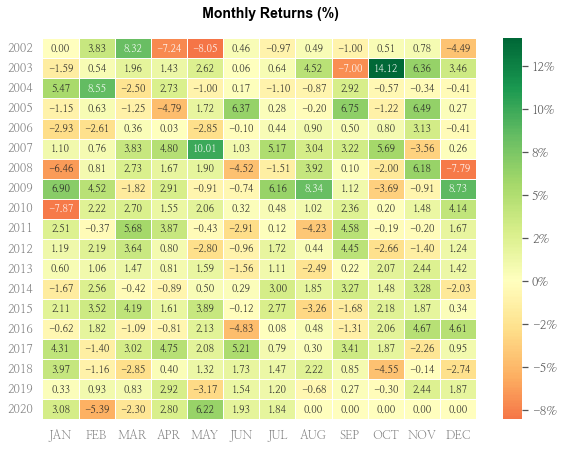

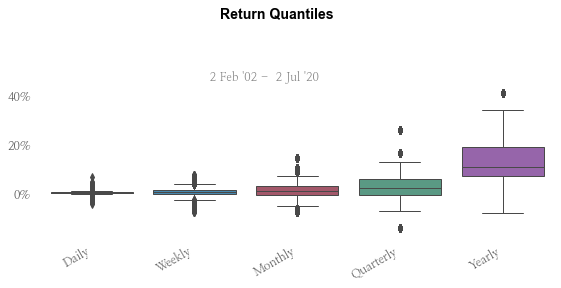

In [21]:
qs.reports.full(r_all['통합'].prices.to_returns().dropna(), 
                r_all['kbase123'].prices.to_returns().dropna())

In [22]:
import warnings
warnings.filterwarnings(action='ignore')
def 투자시점별CAGRMDD(backtest):
    """

    Args:
        end : 백테스트기간 종료보다 1년전 날짜 설정, cagr이 연률화이기 때문에 1년 미만은 과대한 수치를 보여준다.
    """
    r = bt.run(backtest)
    cagrs = {}
    mdds = {}
    #for m in pd.date_range(start_date, '2021-10', freq='M'):
    # 전수를 하려면 아래, 월별로 하려면 위의 루프를 실행한다.
    for m in r.prices.index:
        # print(m)
        try:
            cagrs[m] = r.prices[m:].calc_cagr().values[0]
            mdds[m] = r.prices[m:].calc_max_drawdown().values[0]
        except:
            print(m)

    cagr_df = pd.DataFrame([cagrs]).T*100
    mdd_df = pd.DataFrame([mdds]).T*100

    tdf = bt.merge(cagr_df, mdd_df)
    tdf.columns = ['cagr', 'mdd']

    end = r.prices.index[-1] - pd.DateOffset(years=1)

    ####### plot
    # tdf[:end].plot(figsize=(12,6)) # area의 경우 cagr negative문제 있음
    df = tdf[:end]
    fig, ax = plt.subplots(figsize=(12,6))
    # split dataframe df into negative only and positive only values
    df_neg, df_pos = df.clip(upper=0), df.clip(lower=0)
    # stacked area plot of positive values
    df_pos.plot.area(ax=ax, stacked=True, linewidth=0.)
    # reset the color cycle
    ax.set_prop_cycle(None)
    # stacked area plot of negative values, prepend column names with '_' such that they don't appear in the legend
    df_neg.rename(columns=lambda x: '_' + x).plot.area(ax=ax, stacked=True, linewidth=0.)
    # rescale the y axis
    ax.set_ylim([df_neg.sum(axis=1).min(), df_pos.sum(axis=1).max()])

2020-07-02 00:00:00


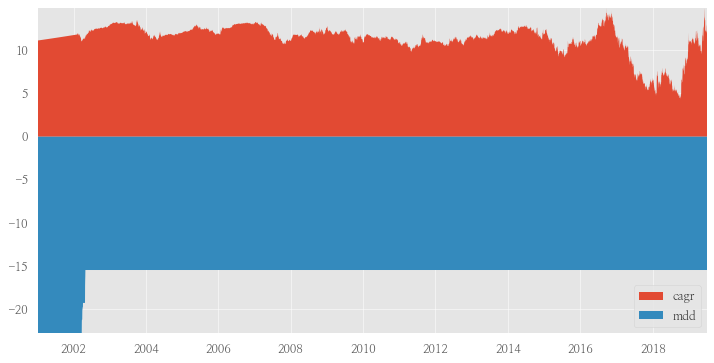

In [23]:
투자시점별CAGRMDD(bt_통합)


2020-07-02 00:00:00


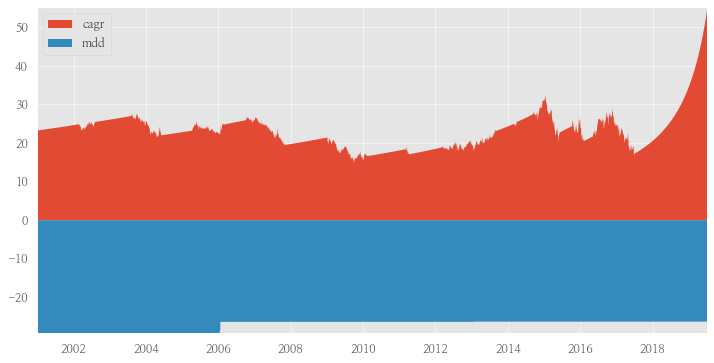

In [24]:
투자시점별CAGRMDD(bt_kbase1)

2020-07-02 00:00:00


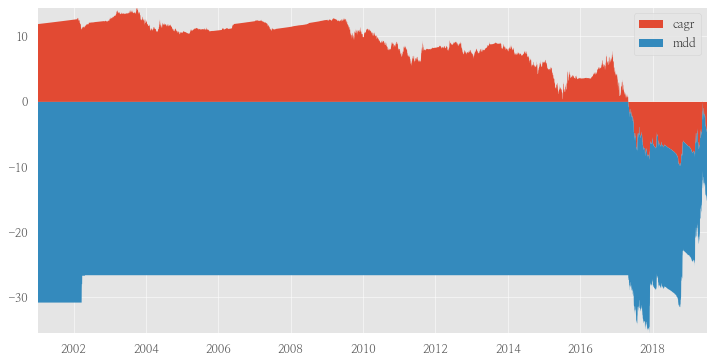

In [25]:
투자시점별CAGRMDD(bt_kbase2)

2020-07-02 00:00:00


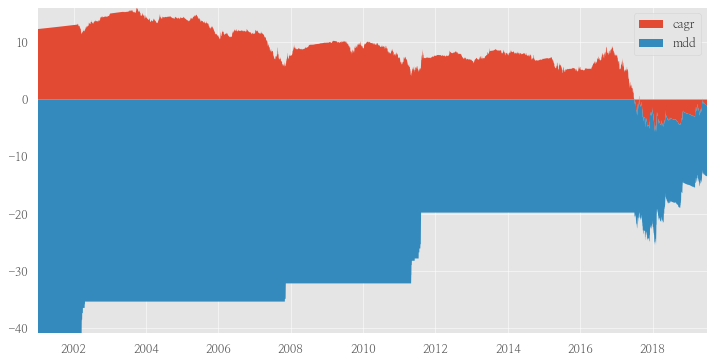

In [26]:
투자시점별CAGRMDD(bt_kbase3)

2020-07-02 00:00:00


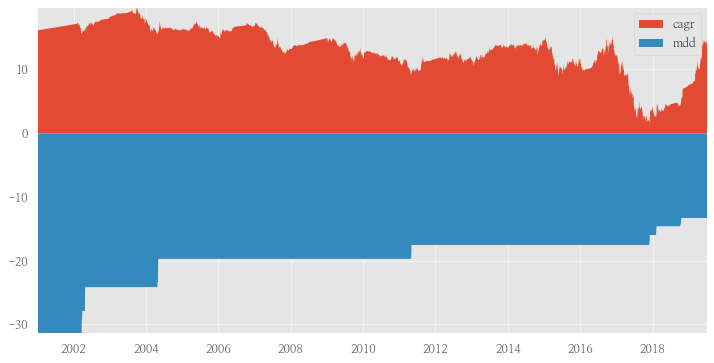

In [27]:
투자시점별CAGRMDD(bt_kbase123)

2020-07-02 00:00:00


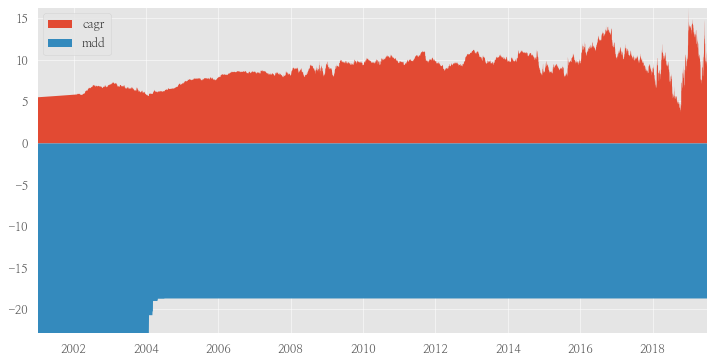

In [28]:
투자시점별CAGRMDD(bt_나스닥다우동일비중AMS)